### Import Libraries

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

### Load and Prepare the Data

In [61]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
n_samples, nx, ny = x_train.shape
n_samples_test, nx_test, ny_test = x_test.shape

x_train = x_train.reshape((n_samples, nx, ny, 1))
y_train = to_categorical(y_train)

x_test = x_test.reshape((n_samples_test, nx_test, ny_test, 1))
y_test = to_categorical(y_test)

x_train = x_train.astype('float32')
X_test = x_test.astype('float32')
x_train /= 255
X_test /= 255
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.1, random_state=2)

### Data Generator for augmentation

In [3]:
datagen = ImageDataGenerator(
        rotation_range=15,
        zoom_range=0.15,
        width_shift_range=0.15,
        height_shift_range=0.15)
datagen.fit(x_train)

### Function to Create CNN model

In [8]:
def get_model():
    cnn = Sequential()
    cnn.add(Conv2D(64, 3, activation='relu', padding='same', input_shape=(nx, ny, 1)))
    cnn.add(Conv2D(64, 3, padding='same', activation='relu'))
    cnn.add(MaxPool2D())
    cnn.add(BatchNormalization())
    
    cnn.add(Conv2D(128, 3, padding='same', activation='relu'))
    cnn.add(Conv2D(128, 3, padding='same', activation='relu'))
    cnn.add(MaxPool2D())
    cnn.add(BatchNormalization())
    
    cnn.add(Conv2D(256, 3, padding='same', activation='relu'))
    cnn.add(MaxPool2D())
    
    cnn.add(Flatten())
    cnn.add(BatchNormalization())
    
    cnn.add(Dense(512, activation='relu'))
    cnn.add(Dense(10, activation='softmax'))
    
    cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return cnn

### Train the Model

In [9]:
callbacks_list = [
        EarlyStopping(
            monitor = 'val_loss',
            patience = 5
        )
]

In [11]:
model = get_model()
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=128),
                              epochs = 25, validation_data = (x_val,y_val),
                              steps_per_epoch=len(x_train) / 128, 
                              callbacks=callbacks_list)

Epoch 1/25
421/421 [==============================] - 41s 96ms/step - loss: 0.5591 - accuracy: 0.8192 - val_loss: 0.0852 - val_accuracy: 0.9750
Epoch 2/25
421/421 [==============================] - 40s 94ms/step - loss: 0.1627 - accuracy: 0.9530 - val_loss: 0.0576 - val_accuracy: 0.9828
Epoch 3/25
421/421 [==============================] - 40s 95ms/step - loss: 0.1137 - accuracy: 0.9673 - val_loss: 0.0480 - val_accuracy: 0.9858
Epoch 4/25
421/421 [==============================] - 41s 97ms/step - loss: 0.0960 - accuracy: 0.9730 - val_loss: 0.0475 - val_accuracy: 0.9868
Epoch 5/25
421/421 [==============================] - 38s 89ms/step - loss: 0.0777 - accuracy: 0.9773 - val_loss: 0.0310 - val_accuracy: 0.9912
Epoch 6/25
421/421 [==============================] - 39s 93ms/step - loss: 0.0698 - accuracy: 0.9803 - val_loss: 0.0257 - val_accuracy: 0.9918
Epoch 7/25
421/421 [==============================] - 40s 96ms/step - loss: 0.0643 - accuracy: 0.9822 - val_loss: 0.0300 - val_accuracy:

### Plot Results

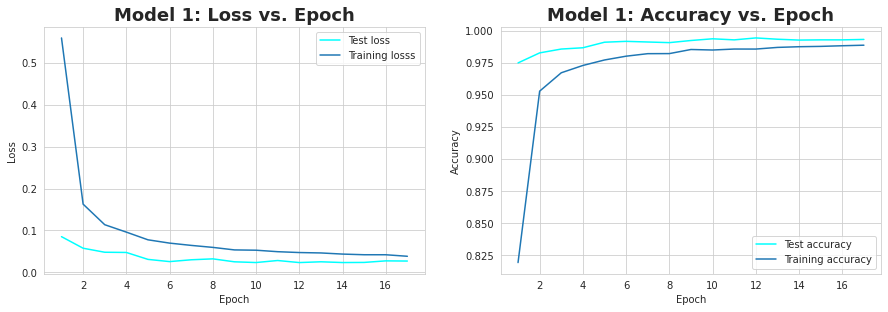

In [20]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid((2,2),(0,0))
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x = list(range(1, len(test_loss) + 1))
plt.plot(x, test_loss, color = 'cyan', label = 'Test loss')
plt.plot(x, train_loss, label = 'Training losss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1: Loss vs. Epoch',weight='bold', fontsize=18)
ax1 = plt.subplot2grid((2,2),(0,1))
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
x = list(range(1, len(test_acc) + 1))
plt.plot(x, test_acc, color = 'cyan', label = 'Test accuracy')
plt.plot(x, train_acc, label = 'Training accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 1: Accuracy vs. Epoch', weight='bold', fontsize=18);

### Accuracy on the test set

In [15]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f'Loss = {loss}')
print(f'Accuracy = {acc}')

Loss = 3.5393624305725098
Accuracy = 0.9939000010490417


### Confusion Matrix

In [16]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)

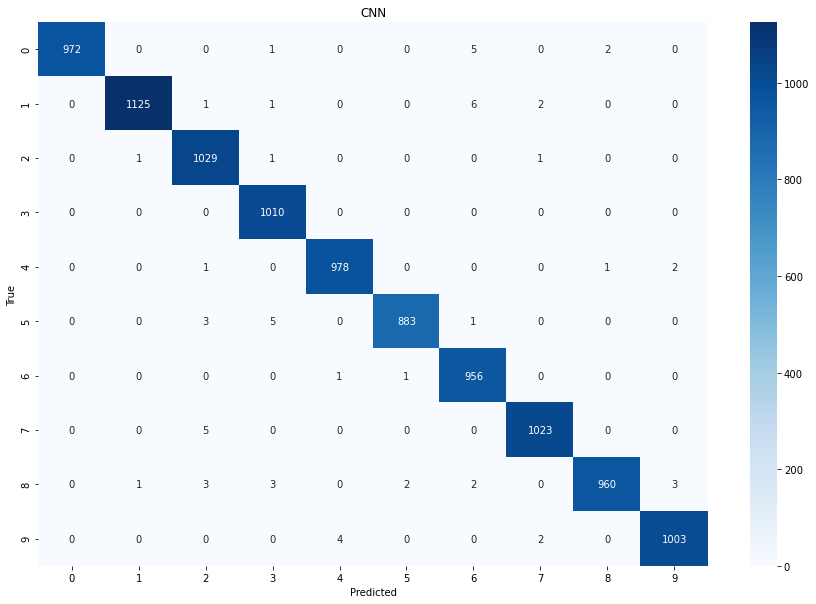

In [17]:
mtx = confusion_matrix(np.argmax(y_test, axis=-1), y_pred)

fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(mtx, annot=True, fmt='d', ax=ax, cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('CNN');

### Save the Model

In [12]:
model.save("model.h5")